<a href="https://colab.research.google.com/github/duanzhihua/-transformer-english2chinese-/blob/main/LangGraph_%E7%AF%87_%E6%9C%83%E8%AD%B0%E8%A8%98%E9%8C%84%E7%B8%BD%E7%B5%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🥱 LangGraph 篇_會議記錄總結

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).

# 環境建置

## 安裝套件包

在本演練中，

我們將使用以下套件：

In [ ]:
%pip install --upgrade --quiet langchain
%pip install --upgrade --quiet langchain-openai
%pip install --upgrade --quiet langgraph

我們需要設置 環境變數 `OPENAI_API_KEY` ，可以直接完成，如下所示：

In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

### (可用可不用)LangSmith

你用LangChain構建的許多應用程式將包含多個步驟，並多次調用LLM調用。隨著這些應用程式變得越來越複雜，能夠檢查您的鏈或代理內部到底發生了什麼變得至關重要。最好的方法是與[LangSmith](https://smith.langchain.com)合作。

請注意，LangSmith 不是必需的，但它很有説明。如果您確實想使用 LangSmith，請在上面的鏈接中註冊后，請確保設置環境變數以開始記錄跟蹤：

In [ ]:
import os
import getpass
from datetime import datetime
import pytz

current_time = datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %Z")

os.environ["LANGCHAIN_TRACING_V2"] = "false" ##想要使用記得改 true, 不要時改 false.
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = f"LangGraph 會議總結-{current_time}"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

# 開始會議記錄設計

## 建立 LLM

In [ ]:
from langchain_openai import ChatOpenAI

# 創建LLM實例
llm = ChatOpenAI(
    # model_name="gpt-4",  # 修改模型版本
    temperature=0.7,     # 調整溫度
    max_tokens=1024      # 設定最大輸出 token 量
)

## 建立狀態

In [ ]:
from typing import List
from pydantic import BaseModel, Field
from langchain_core.pydantic_v1 import BaseModel

# 使用Pydantic定義數據模型
class AgendaItem(BaseModel):
    topic: str = Field(description="議程項目的主題")
    discussion: str = Field(default="", description="關於該主題的討論")
    action_items: List[str] = Field(default_factory=list, description="相關的行動項目")

class MeetingState(BaseModel):
    transcript: str = Field(description="會議的完整記錄")
    agenda_items: List[AgendaItem] = Field(default_factory=list, description="會議的議程項目列表")
    summary: str = Field(default="", description="會議的總結")

## 建立節點

In [ ]:
import re
from langchain_core.messages import HumanMessage

def extract_agenda_items(state: MeetingState) -> MeetingState:
    """從會議記錄中提取議程項目"""
    response = llm.invoke([HumanMessage(content=f"從以下會議記錄中提取主要議程項目，並以Python列表格式返回，每個項目只包含主題：\n{state.transcript}")])

    topics = re.findall(r"'([^']+)'", response.content) # 使用正則表達式提取議程項目

    state.agenda_items = [AgendaItem(topic=topic.strip()) for topic in topics if topic.strip()]

    return state

def process_agenda_items(state: MeetingState) -> MeetingState:
    """處理每個議程項目，添加討論內容和行動項目"""
    for item in state.agenda_items:
        response = llm.invoke([HumanMessage(content=f"對於議題'{item.topic}'，請從以下會議記錄中提取相關的討論內容和行動項目。請使用以下格式：\n討論：[討論內容]\n行動項目：\n- [行動項目1]\n- [行動項目2]\n...\n\n會議記錄：\n{state.transcript}")])

        # 分割討論和行動項目
        parts = response.content.split("行動項目：")
        if len(parts) == 2:
            discussion, actions = parts
            item.discussion = discussion.replace("討論：", "").strip()
            item.action_items = [action.strip().lstrip("- ") for action in actions.split("\n") if action.strip()]
        else:
            item.discussion = response.content
    return state

def generate_summary(state: MeetingState) -> MeetingState:
    """生成會議總結"""
    agenda_summary = "\n".join([f"- {item.topic}" for item in state.agenda_items])
    response = llm.invoke([HumanMessage(content=f"請根據以下議程項目生成一個簡潔的會議總結：\n{agenda_summary}")])
    state.summary = response.content
    return state

## 建立圖，並連接節點與邊

In [ ]:
import os
from langgraph.graph import END, Graph

# 創建圖
workflow = Graph()

# 添加節點
workflow.add_node("extract_agenda", extract_agenda_items)
workflow.add_node("process_agenda", process_agenda_items)
workflow.add_node("summarize", generate_summary)

# 定義邊
workflow.add_edge("extract_agenda", "process_agenda")
workflow.add_edge("process_agenda", "summarize")
workflow.add_edge("summarize", END)

# 設置入口點
workflow.set_entry_point("extract_agenda")

# 編譯圖
app = workflow.compile()

## 可視化當前節點

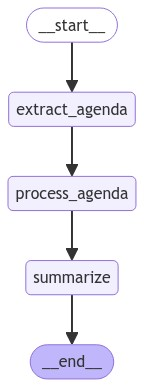

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## 開始與圖對話

In [ ]:
# 使用示例
initial_state = MeetingState(
    transcript="""
    會議開始於9:00 AM。Alice歡迎所有人並介紹了會議議程。

    首先，Bob報告了Q2的銷售數據。銷售額比去年同期增長了15%。團隊討論了新產品線對銷售增長的影響。
    行動項目：準備詳細的產品線性能報告。

    接著，Carol提出了客戶服務改進計劃。她建議實施新的票務系統來提高響應時間。
    行動項目：研究票務系統選項並在下次會議上提出建議。

    最後，Dave更新了即將到來的市場營銷活動。團隊同意將預算增加10%以擴大社交媒體影響力。
    行動項目：修訂營銷預算並發送給財務部門審批。

    會議在10:30 AM結束，下次會議定於下週二。
    """
)

result: MeetingState = app.invoke(initial_state, debug=False)

In [ ]:
print(result)

transcript='\n    會議開始於9:00 AM。Alice歡迎所有人並介紹了會議議程。\n\n    首先，Bob報告了Q2的銷售數據。銷售額比去年同期增長了15%。團隊討論了新產品線對銷售增長的影響。\n    行動項目：準備詳細的產品線性能報告。\n\n    接著，Carol提出了客戶服務改進計劃。她建議實施新的票務系統來提高響應時間。\n    行動項目：研究票務系統選項並在下次會議上提出建議。\n\n    最後，Dave更新了即將到來的市場營銷活動。團隊同意將預算增加10%以擴大社交媒體影響力。\n    行動項目：修訂營銷預算並發送給財務部門審批。\n\n    會議在10:30 AM結束，下次會議定於下週二。\n    ' agenda_items=[AgendaItem(topic='報告Q2銷售數據及討論新產品線影響', discussion='報告Q2銷售數據及討論新產品線影響', action_items=['準備詳細的產品線性能報告。', '研究票務系統選項並在下次會議上提出建議。', '修訂營銷預算並發送給財務部門審批。']), AgendaItem(topic='客戶服務改進計劃及研究票務系統選項', discussion='客戶服務改進計劃及研究票務系統選項', action_items=['準備詳細的新票務系統選項報告。', '在下次會議上提出新的票務系統選項建議。']), AgendaItem(topic='市場營銷活動更新及修訂營銷預算', discussion='市場營銷活動更新及修訂營銷預算', action_items=['準備詳細的產品線性能報告。', '研究票務系統選項並在下次會議上提出建議。', '修訂營銷預算並發送給財務部門審批。'])] summary='會議總結：\n在本次會議中，我們首先報告了第二季度的銷售數據，並討論了新產品線對銷售的影響。接著我們討論了客戶服務改進計劃，並研究了不同的票務系統選項。最後，我們更新了市場營銷活動，並修訂了營銷預算。這次會議為我們的未來工作指明了方向，我們將積極執行相應的計劃和措施以提升業務表現。'


In [ ]:
print(result.summary)
print("\n議程項目：")
for item in result.agenda_items:
    print(f"\n主題：{item.topic}")
    print(f"討論：{item.discussion}")

會議總結：
在本次會議中，我們首先報告了第二季度的銷售數據，並討論了新產品線對銷售的影響。接著我們討論了客戶服務改進計劃，並研究了不同的票務系統選項。最後，我們更新了市場營銷活動，並修訂了營銷預算。這次會議為我們的未來工作指明了方向，我們將積極執行相應的計劃和措施以提升業務表現。

議程項目：

主題：報告Q2銷售數據及討論新產品線影響
討論：報告Q2銷售數據及討論新產品線影響
行動項目：['準備詳細的產品線性能報告。', '研究票務系統選項並在下次會議上提出建議。', '修訂營銷預算並發送給財務部門審批。']

主題：客戶服務改進計劃及研究票務系統選項
討論：客戶服務改進計劃及研究票務系統選項
行動項目：['準備詳細的新票務系統選項報告。', '在下次會議上提出新的票務系統選項建議。']

主題：市場營銷活動更新及修訂營銷預算
討論：市場營銷活動更新及修訂營銷預算
行動項目：['準備詳細的產品線性能報告。', '研究票務系統選項並在下次會議上提出建議。', '修訂營銷預算並發送給財務部門審批。']


## 反思與延伸作業
恭喜你完成了這個使用 LangGraph 和 LLM 處理會議記錄的實踐！現在讓我們進行一些反思，並探索如何進一步應用和擴展你所學到的知識。




### 反思問題

1. 系統的優勢與局限性：
  - 這個系統相比傳統的手動會議記錄方法有什麼優勢？
  - 你認為這個系統可能存在哪些局限性或潛在問題？

2. LLM 的應用：
  - 在這個項目中，LLM 扮演了什麼角色？它如何改變了我們處理文本信息的方式？

3. 工作流程設計：
  - LangGraph 如何幫助我們組織複雜的工作流程？
  - 你認為這種工作流程設計方法可以應用到哪些其他領域？


###延伸作業

1. 功能擴展：
  - 嘗試添加一個新的節點來識別會議中的關鍵決策點。
  - 實現一個功能來自動生成會議的後續行動項目列表。


通過完成這些反思和作業，你將能夠更深入地理解 LangGraph 和 LLM 在實際應用中的潛力和挑戰，並培養將這些技術應用到其他領域的能力。祝你學習愉快，期待看到你的創新想法！